<a href="https://colab.research.google.com/github/rajeevfromkrec/pytorch/blob/master/resnet9%20model%20in%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import os
import torch
import torchvision
import tarfile
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.utils import make_grid




In [43]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['labels.txt', 'train', 'test']
['bird', 'airplane', 'cat', 'ship', 'deer', 'automobile', 'truck', 'frog', 'dog', 'horse']


In [44]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [45]:
train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)])

In [46]:
val_tfms=tt.Compose([tt.ToTensor(),
                     tt.Normalize(*stats,inplace=True)])

In [47]:
train_ds=ImageFolder(data_dir+'/train' ,train_tfms)
val_ds=ImageFolder(data_dir+'/test' ,train_tfms)

In [48]:
batch_size=400

train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size,num_workers=4,pin_memory=True)

In [49]:
def show_batch(dl):
  for images,labels in dl:
    fig,ax=plt.subplots(figsize=(12,12))
    plt.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


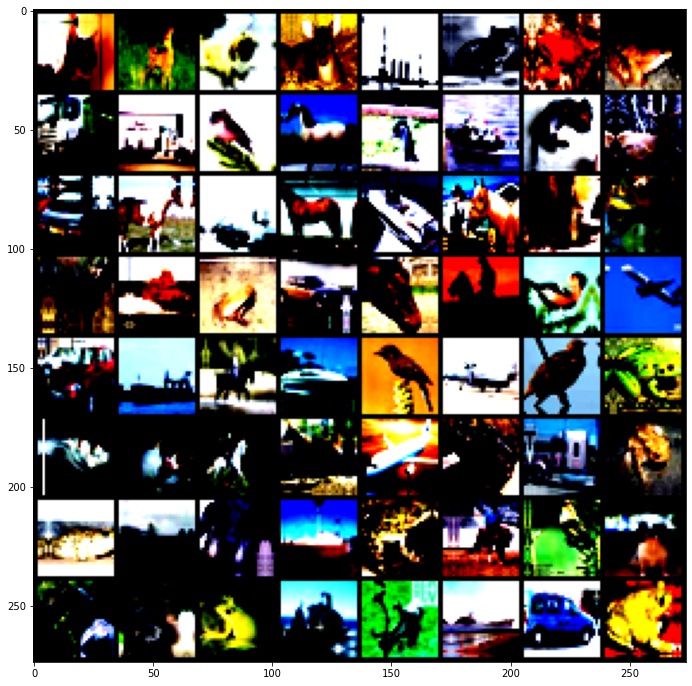

In [50]:
show_batch(train_loader)

In [51]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cpu')

In [53]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [57]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input


In [58]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [60]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [31]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_group:
    return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                          weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch_cuda.empty.cache()
  history=[]
  optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()
    

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [32]:
history= evaluate(model,valid_dl)

NameError: ignored